# Analyse des données du challenge 25 de [datascience.net](http://www.datascience.net)

Ceci est le notebook de ma solution au challenge 25 *Le Meilleur Data Scientist de France* de [datascience.net](http://www.datascience.net).


---

* **Modèle actuel :** Random Forest avec 200 estimators; formule du 'logprix' = log(1+log(1+log(prix)))

---
* **Résultat au 16/10/2016 :** 24ème avec un score de $\sim$29.84%.
* **Résultat final :** n/a

---

## Importation des librairies
Commençons par importer les librairies nécessaires pour notre analyse

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.model_selection import ShuffleSplit, train_test_split

Continuons en spécifiant quelques paramètres esthétiques pour les outputs.

In [2]:
np.random.seed(sum(map(ord, "aesthetics")))
sns.set_context('notebook')

#pd.set_option('display.mpl_style', 'default') # Make the graphs a bit prettier
plt.style.use('bmh')

plt.rcParams['figure.figsize'] = (15, 5)

# Set some Pandas options
pd.set_option('display.notebook_repr_html', True)
pd.set_option('display.max_columns', 99) # permet de voir toutes les colonnes
pd.set_option('display.max_rows', 25)
pd.options.display.max_colwidth = 50

## Importation des données et visualisation
Nous allons ensuite importer les données à analyser et en visualiser les 5 premiers éléments de chaque dataset.

In [3]:
data_train = pd.read_csv('../data_challenge/boites_medicaments_train.csv', encoding='utf-8', sep=';')
data_test = pd.read_csv('../data_challenge/boites_medicaments_test.csv', encoding='utf-8', sep=';')
print(data_train.head(5))
print(data_test.head(5))

                                             libelle  libelle_plaquette  \
0  3 plaquette(s) thermoformée(s) PVC-Aluminium d...                  1   
1  plaquette(s) thermoformée(s) aluminium de 28 c...                  1   
2  plaquette(s) thermoformée(s) PVC-aluminium de ...                  1   
3  30 sachet(s)-dose(s) papier aluminium complexe...                  0   
4  plaquette(s) thermoformée(s) PVC-Aluminium de ...                  1   

   libelle_ampoule  libelle_flacon  libelle_tube  libelle_stylo  \
0                0               0             0              0   
1                0               0             0              0   
2                0               0             0              0   
3                0               0             0              0   
4                0               0             0              0   

   libelle_seringue  libelle_pilulier  libelle_sachet  libelle_comprime  \
0                 0                 0               0                 1

## Analyse descriptive
### Structure des datasets

In [4]:
print('Les données train ont ' + str(data_train.shape[0]) + ' observables, de ' + str(data_train.shape[1]) + ' variables chacune.')
print('Les données test ont ' + str(data_test.shape[0]) + ' observables, de ' + str(data_test.shape[1]) + ' variables chacune.')
print()
print('----- Data train Keys -----')
for k in data_train.keys():
    print (k)
print('----- Data test Keys -----')
for k in data_test.keys():
    print(k) 

Les données train ont 8564 observables, de 41 variables chacune.
Les données test ont 3671 observables, de 41 variables chacune.

----- Data train Keys -----
libelle
libelle_plaquette
libelle_ampoule
libelle_flacon
libelle_tube
libelle_stylo
libelle_seringue
libelle_pilulier
libelle_sachet
libelle_comprime
libelle_gelule
libelle_film
libelle_poche
libelle_capsule
nb_plaquette
nb_ampoule
nb_flacon
nb_tube
nb_stylo
nb_seringue
nb_pilulier
nb_sachet
nb_comprime
nb_gelule
nb_film
nb_poche
nb_capsule
nb_ml
statut
etat commerc
agrement col
tx rembours
forme pharma
voies admin
statut admin
date declar annee
date amm annee
type proc
titulaires
substances
prix
----- Data test Keys -----
id
libelle
libelle_plaquette
libelle_ampoule
libelle_flacon
libelle_tube
libelle_stylo
libelle_seringue
libelle_pilulier
libelle_sachet
libelle_comprime
libelle_gelule
libelle_film
libelle_poche
libelle_capsule
nb_plaquette
nb_ampoule
nb_flacon
nb_tube
nb_stylo
nb_seringue
nb_pilulier
nb_sachet
nb_comprime
nb_ge

Il est **très** important de lire la [description des variables](https://www.datascience.net/fr/challenge/25/details#tab_brief71), afin de correctement appréhender le problème.

### Que cherchons-nous à prédire?
Nous cherchons à développer un modèle prédictif permettant d'estimer le coût d'une boîte de médicament.

Commençons donc par étudier la distribution des prix dans les données train.

### Description des données

In [5]:
data_train['prix'].value_counts()

6.36     364
18.63    333
8.14      93
23.71     86
7.55      81
1.08      79
3.94      79
7.21      74
5.27      68
3.49      65
8.13      57
5.91      48
        ... 
31.09      1
58.46      1
56.40      1
54.40      1
50.27      1
49.52      1
48.65      1
25.12      1
46.15      1
45.21      1
23.12      1
0.75       1
Name: prix, dtype: int64

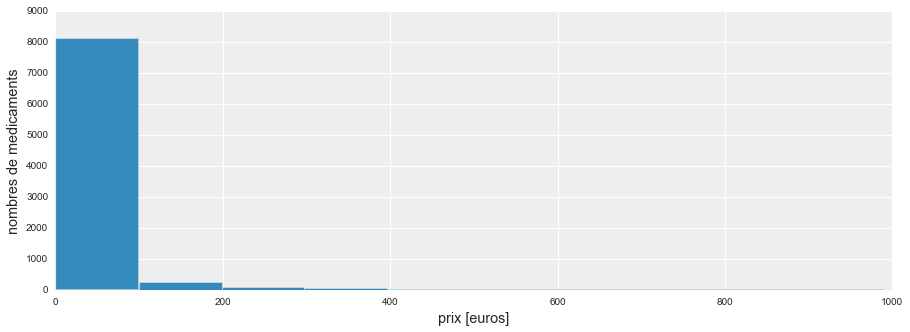

In [6]:
ax = data_train['prix'].hist()
ax.set_xlabel('prix [euros]')
ax.set_ylabel('nombres de medicaments')

Ce n'est pas très joli. Essayons d'améliorer les choses en prenant le logarithme des prix.

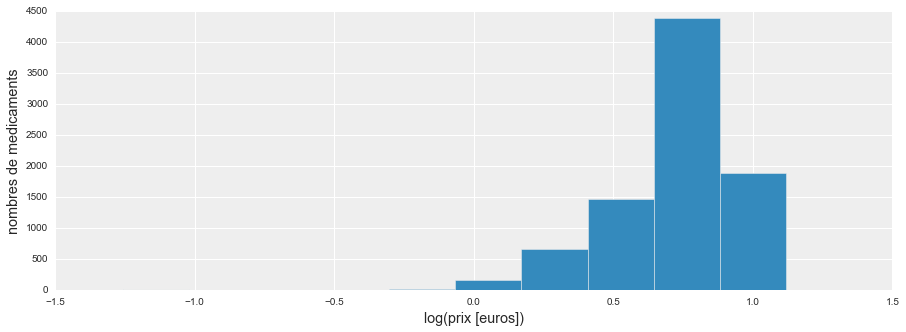

In [19]:
data_train['logprix'] = ((data_train['prix'].apply(np.log)+1).apply(np.log)+1).apply(np.log)
ax = data_train['logprix'].hist()
ax.set_xlabel('log(prix [euros])')
ax.set_ylabel('nombres de medicaments')

C'est un peu plus joli. Nous avons une belle distribution, proche d'une gaussienne.

### Critère de performance
Le challenge utilise la métrique [MAPE](https://en.wikipedia.org/wiki/Mean_absolute_percentage_error). Celle-ci n'étant pas disponible dans sklearn, nous la codons manuellement :

In [8]:
# Mean Absolute Percentage Error
def mape_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

## Préparation des données
### Séparation des différents types de variables
Nous constatons, en analysant les variables disponibles, qu'elles sont de quatre types différentes :
* numérique  
* catégorielle  
* date  
* texte

Nous constatons également que les taux de remboursements (qui peuvent jouer un role important sur le prix final) sont des *string* ayant un symbol $%$ à la fin. Nettoyons cette variable et convertissons la en *int*.

In [9]:
data_train['reimburse rate'] = (data_train["tx rembours"].str.rstrip("%")).apply(int)
data_test['reimburse rate'] = (data_test["tx rembours"].str.rstrip("%")).apply(int)

In [10]:
data_train['reimburse rate'].head(10)

0     65
1     65
2     65
3     65
4    100
5    100
6    100
7     65
8     65
9     65
Name: reimburse rate, dtype: int64

### Séparations des variables à plusieurs éléments
Une autre chose que nous constatons est que les variables *voies admin*, *titulaires* et *substances* peuvent comporter plusieurs éléments séparés par une virgule. "Explosons" ces variables.

In [11]:
temp = data_train['voies admin'].apply(lambda st : st.split(','))
admins = set([l for j in temp for l in j])
for voie in admins:
    data_train[voie] = data_train['voies admin'].apply(lambda x : 1 if voie in x else 0)
    data_test[voie] = data_test['voies admin'].apply(lambda x : 1 if voie in x else 0)

In [12]:
temp = data_train['titulaires'].apply(lambda st : st.split(','))
labos = set([l for j in temp for l in j])
for lab in labos:
    data_train[lab] = data_train['titulaires'].apply(lambda x : 1 if lab in x else 0)
    data_test[lab] = data_test['titulaires'].apply(lambda x : 1 if lab in x else 0)

In [13]:
temp = data_train['substances'].apply(lambda st : st.split(','))
data_train['nb_sub'] = data_train['substances'].apply(lambda st : len(st.split(',')))
data_test['nb_sub'] = data_test['substances'].apply(lambda st : len(st.split(',')))
subs = set([l for j in temp for l in j])
for s in subs:
    data_train[s] = data_train['substances'].apply(lambda x : 1 if s in x else 0)
    data_test[s] = data_test['substances'].apply(lambda x : 1 if s in x else 0)

In [14]:
# variables numériques
var_lib = ['libelle_plaquette', 'libelle_ampoule', 'libelle_flacon', 
            'libelle_tube', 'libelle_stylo', 'libelle_seringue',
            'libelle_pilulier', 'libelle_sachet', 'libelle_comprime', 
            'libelle_gelule', 'libelle_film', 'libelle_poche',
            'libelle_capsule']
var_nb = ['nb_plaquette', 'nb_ampoule', 
            'nb_flacon', 'nb_tube', 'nb_stylo', 'nb_seringue',
            'nb_pilulier', 'nb_sachet', 'nb_comprime', 'nb_gelule', 
            'nb_film', 'nb_poche', 'nb_capsule', 'nb_ml']
var_num = var_lib + var_nb+ ['reimburse rate']
# variables catégorielles
var_cat = ['statut', 'etat commerc', 'agrement col', 'tx rembours',
          'statut admin', 'type proc', 'forme pharma']
# variables dates
var_dates = ['date declar annee', 'date amm annee']

# variable texte
var_txt = ['libelle', 'titulaires', 'substances']

var_admin = list(admins) # voies admin
var_lab = list(labos) # titulaires
var_sub = list(subs)+['nb_sub'] # substances

#var_dupl = var_num + var_cat + var_dates + var_txt + var_admin

### Encodage des variables catégorielles
Nous avons besoin de transformer les variables catégorielles en nombre, afin de pouvoir les utiliser dans les algorithmes de machine learning (qui nécessitent des nombres comme paramètres d'entrée).

Pour cela, nous allons utiliser la fonction [*LabelEncoder()*](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html)

In [15]:
data_train[var_cat].head(10)

,statut,etat commerc,agrement col,tx rembours,statut admin,type proc,forme pharma
0,Présentation active,Déclaration de commercialisation,oui,65%,Autorisation active,Procédure décentralisée,comprimé pelliculé
1,Présentation active,Déclaration de commercialisation,oui,65%,Autorisation active,Procédure de reconnaissance mutuelle,comprimé à croquer
2,Présentation active,Déclaration de commercialisation,oui,65%,Autorisation active,Procédure nationale,gélule à libération prolongée
3,Présentation active,Déclaration de commercialisation,oui,65%,Autorisation active,Procédure nationale,granulés à libération prolongée
4,Présentation active,Déclaration d'arrêt de commercialisation,non,100%,Autorisation active,Procédure nationale,comprimé pelliculé
5,Présentation active,Déclaration de commercialisation,oui,100%,Autorisation active,Procédure nationale,comprimé
6,Présentation active,Déclaration de commercialisation,oui,100%,Autorisation active,Procédure centralisée,capsule molle
7,Présentation active,Déclaration de commercialisation,oui,65%,Autorisation active,Procédure de reconnaissance mutuelle,comprimé
8,Présentation active,Déclaration d'arrêt de commercialisation,oui,65%,Autorisation active,Procédure nationale,comprimé sécable
9,Présentation active,Déclaration de commercialisation,non,65%,Autorisation active,Procédure nationale,comprimé pelliculé


In [16]:
for c in var_cat:
    le = LabelEncoder()
    le.fit(data_train[c].append(data_test[c]))
    data_train[c] = le.transform(data_train[c])
    data_test[c] = le.transform(data_test[c])

In [17]:
data_train[var_cat].head(10)

,statut,etat commerc,agrement col,tx rembours,statut admin,type proc,forme pharma
0,1,2,1,4,1,3,36
1,1,2,1,4,1,2,55
2,1,2,1,4,1,4,92
3,1,2,1,4,1,4,86
4,1,1,0,1,1,4,36
5,1,2,1,1,1,4,8
6,1,2,1,1,1,1,1
7,1,2,1,4,1,2,8
8,1,1,1,4,1,4,50
9,1,2,0,4,1,4,36


## Création du modèle prédictif
Nous sommes maintenant prêt à définir un modèle prédictif des prix des médicaments.

Nous allons utiliser un modèle *Random Forest Regression*

Nous allons également utiliser toutes les variables à notre disposition, excepté les variables textuelles.

Enfin, afin d'éviter le [surapprentissage](https://fr.wikipedia.org/wiki/Surapprentissage) et correctement estimer les performances de nos modèles, nous allons utiliser la [validation croisée](https://fr.wikipedia.org/wiki/Validation_crois%C3%A9e) avec le critère *k-fold*.

## Random Forest Regression

In [20]:
NBROUND = 5
VARIABLES = var_sub + var_num+var_admin+var_cat
# Random Forest Model
params = {'n_estimators': 200, 'n_jobs':-1}
err = 0
for train_index, test_index in KFold(n_splits=NBROUND).split(data_train):
    y = data_train['logprix']
    X = data_train[VARIABLES]
    X_train, X_test = X.ix[train_index, :], X.ix[test_index, :]
    y_train, y_test = y[train_index], y[test_index]
    gbrt = RandomForestRegressor(**params)
    gbrt.fit(X_train, y_train)
    pred = gbrt.predict(X_test)
    # ne pas oublier de reprendre l'exponentielle de la prédiction
    #exp(-1+exp(-1+exp(h2o.res)))
    err += mape_error(np.exp(-1+np.exp(-1+np.exp(y_test))), np.exp(-1+np.exp(-1+np.exp(pred))))
    #err += mape_error(np.exp(y_test), np.exp(pred))
    #print (mape_error(np.exp(y_test), np.exp(pred)))
print ("*** Random Forest MAPE Error : ", err / NBROUND)

*** Random Forest MAPE Error :  33.46499581167983


## Prédictions
Nous allons entrainer le modèle sur un ensemble de variables sélectionnées qui semblent optimiser le score de prédiction

In [21]:
rf = RandomForestRegressor(n_estimators = 200, n_jobs=-1)
VARIABLES = var_sub + var_num+var_admin+var_cat
rf.fit(data_train[VARIABLES], data_train['logprix'])
#predictions_training = np.exp(rf.predict(data_train[VARIABLES]))
predictions = np.exp(-1+np.exp(-1+np.exp(rf.predict(data_test[VARIABLES]))))

## Soumission
Pour finir, nous sauvegardons nos prédictions dans un fichier au bon format pour soumession.

In [22]:
pd.DataFrame(predictions, index=data_test['id']).to_csv('soumission.csv',  
                          header=['prix'],
                          sep = ';')

## Gradient Boosting Regression

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor

In [ ]:
# Ca peut tourner longtemps !!
param_grid={'n_estimators':[100],
            'learning_rate': [0.01, 0.02, 0.05, 0.11],
            'max_depth':[4,6],
            'min_samples_leaf':[3,5,9,17],
            'max_features':[1.0,0.3,0.1]
           }
n_jobs=-1

In [ ]:
NBROUND = 5
VARIABLES = var_sub + var_num+var_admin+var_cat
# Gradient Tree Boosting Model
params = {'n_estimators': 2000, 'max_depth': 6, 'min_samples_split': 3,'learning_rate': 0.01}
#params = {'n_estimators': 1000, 'max_depth': 6, 'min_samples_split': 3,
#          'learning_rate': 0.01, 'max_features': 1.0}
err = 0
for train_index, test_index in KFold(n_splits=NBROUND).split(data_train):
    y = data_train['logprix']
    X = data_train[VARIABLES]
    X_train, X_test = X.ix[train_index, :], X.ix[test_index, :]
    y_train, y_test = y[train_index], y[test_index]
    gbrt = GradientBoostingRegressor(**params)
    gbrt.fit(X_train, y_train)
    pred = gbrt.predict(X_test)
    # ne pas oublier de reprendre l'exponentielle de la prédiction
    err += mape_error(np.exp(y_test), np.exp(pred))
    #print (mape_error(np.exp(y_test), np.exp(pred)))
print ("*** Gradient Tree Boosting MAPE Error : ", err / NBROUND)

In [ ]:
gbrt = GradientBoostingRegressor(**params)
gbrt.fit(data_train[VARIABLES], data_train['logprix'])
# ATTENTION !! Bien penser à transformer les prédictions obtenues dans l'espace linéaire.
predictions = np.exp(gbrt.predict(data_test[VARIABLES]))

In [ ]:
pd.DataFrame(predictions, index=data_test['id']).to_csv('soumission.csv',  
                          header=['prix'],
                          sep = ';')